**Use GPU: Runtime -> Change runtime type -> GPU (Hardware Accelerator)**

Setup

In [3]:
!cat ~/.keras/keras.json

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

Lenet

In [4]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

In [5]:
class LeNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Train LeNet (MNIST)

In [6]:
from keras.optimizers import SGD
from keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def train_lenet_mnist():
    # grab the MNIST dataset (if this is your first time using this
    # dataset then the 11MB download may take a minute)
    print("[INFO] accessing MNIST...")
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()

    # if we are using "channels first" ordering, then reshape the
    # design matrix such that the matrix is:
    # num_samples x depth x rows x columns
    if K.image_data_format() == "channels_first":
        trainData = trainData.reshape((trainData.shape[0], 1, 28, 28))
        testData = testData.reshape((testData.shape[0], 1, 28, 28))

    # otherwise, we are using "channels last" ordering, so the design
    # matrix shape should be: num_samples x rows x columns x depth
    else:
        trainData = trainData.reshape((trainData.shape[0], 28, 28, 1))
        testData = testData.reshape((testData.shape[0], 28, 28, 1))

    # scale data to the range of [0, 1]
    trainData = trainData.astype("float32") / 255.0
    testData = testData.astype("float32") / 255.0

    # convert the labels from integers to vectors
    le = LabelBinarizer()
    trainLabels = le.fit_transform(trainLabels)
    testLabels = le.transform(testLabels)

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01)
    model = LeNet.build(width=28, height=28, depth=1, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    print("[INFO] training network...")
    H = model.fit(trainData, trainLabels, validation_data=(testData, testLabels), batch_size=128, epochs=20, verbose=1)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testData, batch_size=128)
    print(classification_report(testLabels.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in le.classes_]))

    return H

In [8]:
H = train_lenet_mnist()

[INFO] accessing MNIST...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training network...
Epoch 1/20
469/469 [==============================] - 36s 7ms/step - loss: 1.8254 - accuracy: 0.4930 - val_loss: 0.3004 - val_accuracy: 0.9170
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2825 - accuracy: 0.9180 - val_loss: 0.2011 - val_accuracy: 0.9394
Epoch 3/20
469/469 [==============================] - 3s 5ms/step - loss: 0.1899 - accuracy: 0.9449 - val_loss: 0.1512 - val_accuracy: 0.9579
Epoch 4/20
469/469 [==============================] - 3s 5ms/step - loss: 0.1468 - accuracy: 0.9574 - val_loss: 0.1135 - val_accuracy: 0.9664
Epoch 5/20
469/469 [==============================] - 3s 5ms/step - loss: 0.1162 - accuracy: 0.9664 - val_loss: 0.0938 - val_accuracy: 0.9725
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0983 - accuracy: 0.9715 - val_loss: 0.1018 - val_accuracy: 0.9673
Epo

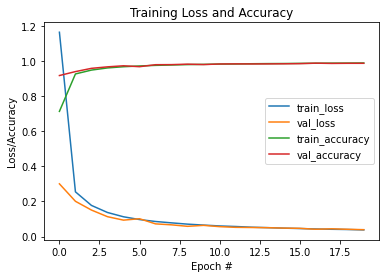

In [9]:
%matplotlib inline

# plot the training loss and accuracy
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()